Workflow of model training.

In [45]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR

Prepare data.

In [ ]:
# configure path to the testing data
file_path = '/home/yangliu/AI4S2S/s2spy/tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
cal = cal.map_to_data(field)
field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target)

In [ ]:
# select data of interest
target_timeseries = target_resampled.sel(cluster=3).ts.isel(i_interval=0)
precursor_field = field_resampled.sst.isel(i_interval=slice(1,5)) # Multiple lags: 1 through 4

Split data as training set (75%, 30 years) and testing set (25%, 9 years).

In [ ]:
# training set
train_year_start = 1980
train_year_end = 2009
precursor_field_train = precursor_field.sel(anchor_year=slice(train_year_start, train_year_end))
target_timeseries_train = target_timeseries.sel(anchor_year=slice(train_year_start, train_year_end))

# testing set
test_year_start = 2010
test_year_end = 2018
precursor_field_test = precursor_field.sel(anchor_year=slice(test_year_start, test_year_end))
target_timeseries_test = target_timeseries.sel(anchor_year=slice(test_year_start, test_year_end))

Perform dimensionality reduction for precursor field.

In [ ]:
# configure RGDR
rgdr = RGDR(eps_km=600, alpha=0.05, min_area_km2=3000**2)
# perform RGDR
rgdr.fit(precursor_field_train, target_timeseries_train)
clustered_data_train = rgdr.transform(precursor_field_train)
clustered_data_test = rgdr.transform(precursor_field_test)
# transform dimensions for model training
clustered_data_train = clustered_data_train.transpose("anchor_year", "cluster_labels")
clustered_data_test = clustered_data_test.transpose("anchor_year", "cluster_labels")

In [53]:
clustered_data_train

<xarray.DataArray 'sst' (anchor_year: 30, cluster_labels: 7)>
array([[286.91668162, 299.84783596, 289.93774506, 297.54843947,
        278.24066238, 286.10327492, 284.25688101],
       [287.01053665, 299.90999519, 290.99665391, 297.70846305,
        278.28356247, 286.84083223, 284.66730471],
       [286.54620289, 298.42320455, 289.64697831, 295.4500786 ,
        279.14810486, 286.19085251, 284.32519283],
       [285.76642198, 299.85415344, 289.79958178, 297.46877566,
        278.55730413, 285.7835013 , 283.63555146],
       [287.28029452, 300.53261312, 290.32029845, 298.61729337,
        278.91383413, 286.93986272, 284.47967082],
       [287.11752036, 298.77104119, 290.61151905, 297.72280291,
        278.97152786, 286.79347391, 284.8633425 ],
       [286.91728331, 299.26571418, 290.95184425, 296.86022156,
        279.06490962, 286.69249845, 285.0038166 ],
       [285.73728271, 299.58077257, 290.1544995 , 295.95557241,
        278.3467481 , 286.25965795, 284.43501001],
       [286.27027317, 300.35477566, 290.1053183 , 298.7395288 ,
        278.16248144, 285.89035   , 284.09578366],
       [287.12407151, 299.47631632, 290.59468686, 297.39734454,
        279.18296738, 286.86859677, 284.88719095],
...
       [287.51545001, 299.90851373, 290.34061042, 298.11604053,
        278.68831329, 285.86874303, 283.83763964],
       [287.4697688 , 300.19267917, 290.31979773, 298.33634933,
        278.50768102, 286.32706228, 284.13051603],
       [287.33929671, 300.05178019, 290.21811635, 297.50691676,
        279.52856318, 286.8266357 , 284.81265618],
       [287.259754  , 299.29538133, 290.75069599, 297.42936244,
        278.6126709 , 286.22619978, 284.37959048],
       [288.19457254, 299.91475186, 291.53432816, 296.19082513,
        279.2724528 , 287.59860329, 284.88366148],
       [287.73373685, 299.87610711, 290.69421445, 298.0900667 ,
        279.67929255, 287.21957964, 285.26486288],
       [286.85064034, 299.8528795 , 290.42994901, 297.67371479,
        278.86642609, 285.85201269, 283.9566866 ],
       [286.16938397, 299.89861688, 290.5898762 , 297.87487282,
        278.4716746 , 286.55275645, 284.31180943],
       [287.67270923, 299.32189297, 290.13167005, 297.69282282,
        278.98851878, 286.96470686, 284.75600036],
       [288.75096715, 300.44966058, 291.05704933, 297.29816477,
        279.8935379 , 287.42835661, 285.22563649]])
Coordinates:
  * anchor_year     (anchor_year) int64 1980 1981 1982 1983 ... 2007 2008 2009
  * cluster_labels  (cluster_labels) <U20 'lag:1_cluster:-1' ... 'lag:4_clust...
    latitude        (cluster_labels) float64 43.89 27.5 34.45 ... 38.79 40.26
    longitude       (cluster_labels) float64 213.4 182.5 226.3 ... 220.7 217.6

Train a gradient boosting machine for regression.

In [ ]:
# Hyperparameters for the boosting machine
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
from sklearn import ensemble
regressor = ensemble.GradientBoostingRegressor(**params)
# the shape of input X must be [samples, features]
regressor.fit(clustered_data_train, target_timeseries_train)

In [ ]:
# score for testing
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(target_timeseries_test, regressor.predict(clustered_data_test))
print("The mean squared error (MSE) on test set: {:.2f}".format(mse))

Plot training deviance.

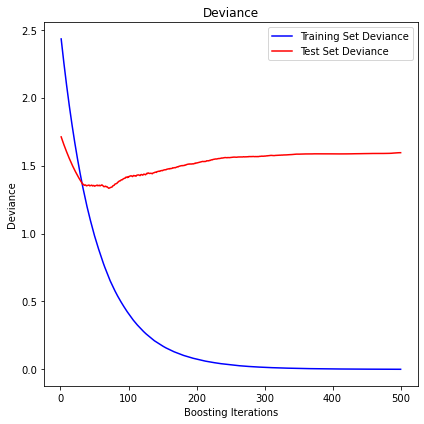

In [46]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, target_timeseries_pred in enumerate(regressor.staged_predict(clustered_data_test)):
    test_score[i] = regressor.loss_(target_timeseries_test, target_timeseries_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    regressor.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Plot feature importance.

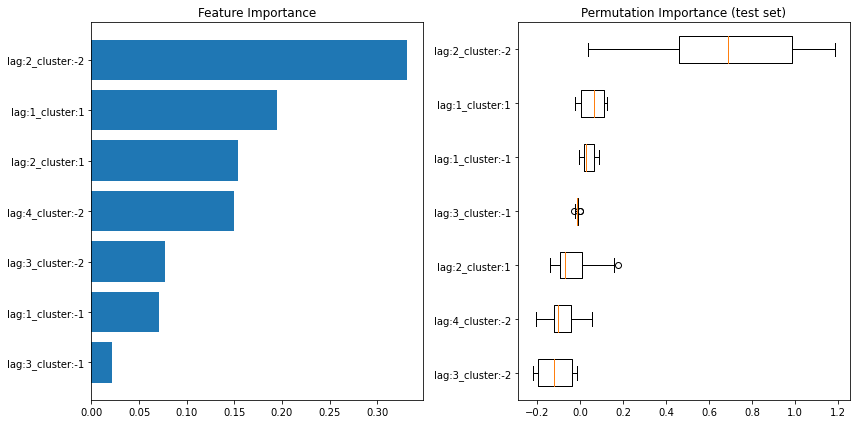

In [52]:
feature_importance = regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(clustered_data_test.cluster_labels)[sorted_idx])
plt.title("Feature Importance")

# also include the permutation impotance score of features
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regressor, clustered_data_test, target_timeseries_test,
    n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(clustered_data_test.cluster_labels)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=13
# )